### 导入必须的数学包和图形库并配置

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import pylab

### 获得未加噪声的数据（x, y），正弦函数，周期为2$\pi$，取样步长为0.1$\pi$，取一个周期

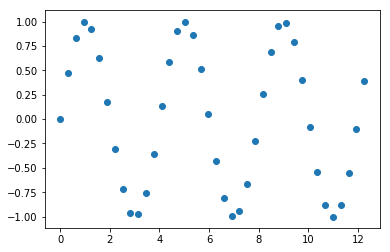

In [2]:
T = 2 * math.pi
n = 2
step = (T / n) * 0.1

x_row = np.arange(0, 2*T, step, float)

y_row = np.sin(math.pi / 2 * x_row)

plt.scatter(x_row, y_row)
plt.show()

### 为数据加上高斯白噪声，均值0，方差0.2

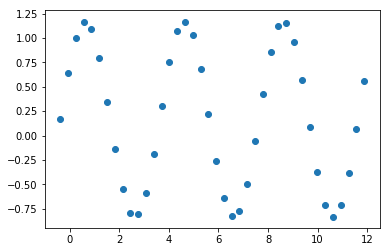

In [3]:
mu = 0
sigma = 0.2

x = x_row + random.gauss(mu, sigma)
y = y_row + random.gauss(mu, sigma)

plt.scatter(x, y)
plt.show()

### 根据最小二乘法使用1-16阶的多项式拟合数据

![](https://tva1.sinaimg.cn/large/006y8mN6ly1g6yyzo0dxrj309902kmx7.jpg)

[[ 4.74646158e-01]
 [ 1.94525124e+00]
 [ 1.31577566e+00]
 [-5.28849369e+00]
 [ 3.70694531e+00]
 [-1.19992144e+00]
 [ 2.14241777e-01]
 [-2.22402725e-02]
 [ 1.32470029e-03]
 [-4.13538987e-05]
 [ 5.10418993e-07]]


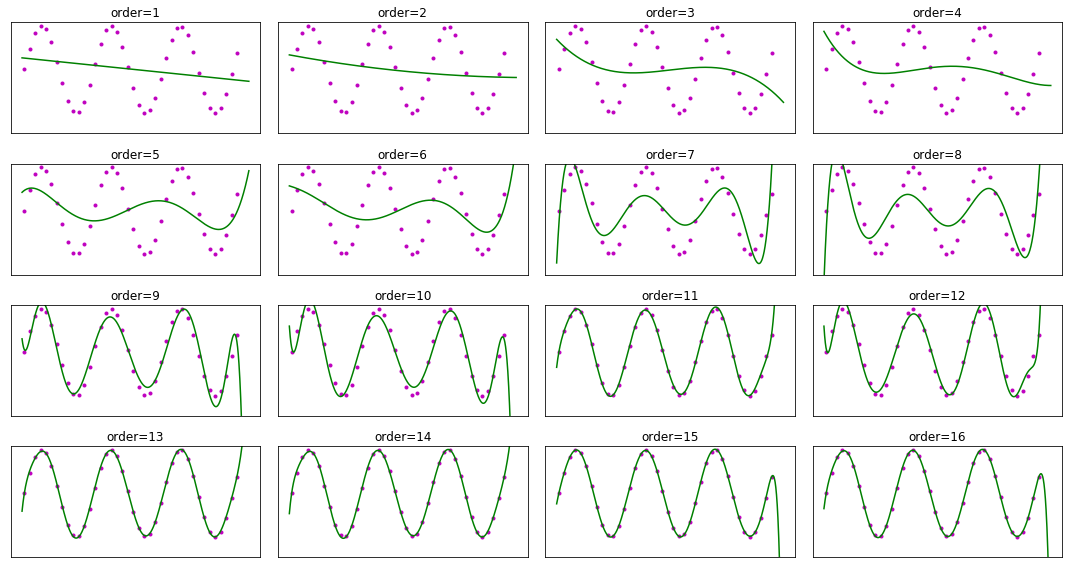

In [57]:
def least_square(x, y, order):
    matrix_left = np.empty([order + 1, order + 1], dtype = float)
    matrix_right = np.empty([order + 1, 1], dtype = float)
    for i in range(0, order + 1):
        row = matrix_left[i]
        for j in range(i, order + 1 + i):
            sum = 0
            for xx in x:
                sum = sum + xx**j
            row[j - i] = sum
    
    for i in range(0, order + 1):
        sum = 0
        j = 0
        for xx in x:
            sum = sum + y[j] * xx**i
            j = j + 1
        matrix_right[i][0] = sum
    
    return np.linalg.solve(matrix_left, matrix_right)

def func_solve(x, a):
    y=0
    for i in range(len(a)):
        y+=a[i]*x**i
    return y

pylab.rcParams['figure.figsize'] = (15.0, 8.0)
for i in range(16):
    ax = plt.subplot(4, 4, 1+i)
    ax.set_title('order=' + str(i+1))
    plt.xticks(())
    plt.yticks(())
    a = least_square(x, y, i+1)
    if i == 9:
        print(a)
    after_x = np.arange(-0.5, 2*T, 0.01)
    after_y = func_solve(after_x, a)
    plt.ylim([-1.3, 1.25])
    plt.plot(x, y, color='m', linestyle='', marker='.')
    plt.plot(after_x,after_y,color='g',linestyle='-',marker='')

plt.tight_layout()
plt.show()

### 120阶可观察过拟合情况

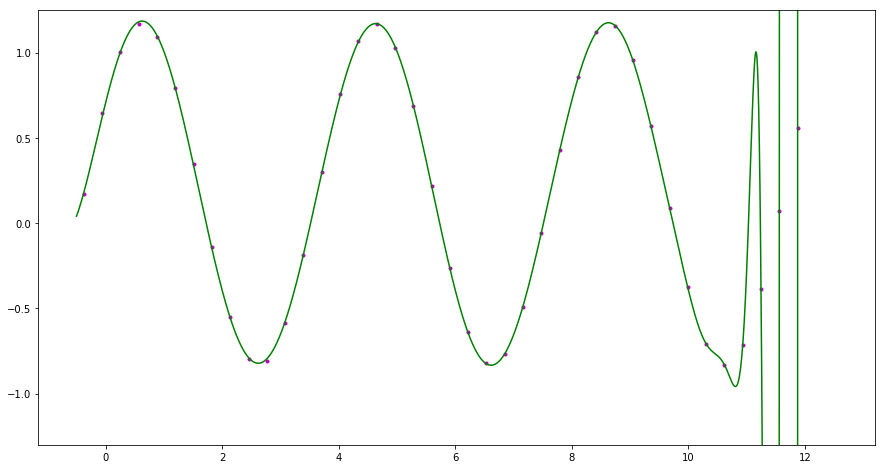

In [5]:
a = least_square(x, y, 120)
after_x = np.arange(-0.5, 2*T, 0.01)
after_y = func_solve(after_x, a)
plt.ylim([-1.3, 1.25])
plt.plot(x, y, color='m', linestyle='', marker='.')
plt.plot(after_x,after_y,color='g',linestyle='-',marker='')
plt.show()

### 最小二乘法的解析解（无正则项）
![](https://tva1.sinaimg.cn/large/006y8mN6ly1g6yy5zwc4aj304v02i0sm.jpg)

![](https://tva1.sinaimg.cn/large/006y8mN6ly1g6ywn8f1vlj3060027weg.jpg)

In [6]:
# 注意此处的x与y是样本的x和y
def analytical_solution_without_regularizer(x, y, order):
    
    matrix_left = np.ones((len(x), order+1), dtype = float)
    
    for i in range(len(x)):
        for j in range(order+1):
            matrix_left[i][j] = x[i]**j
    
    return np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(matrix_left), matrix_left)), np.transpose(matrix_left)),  np.transpose(y))

### 使用解析解拟合10阶多项式

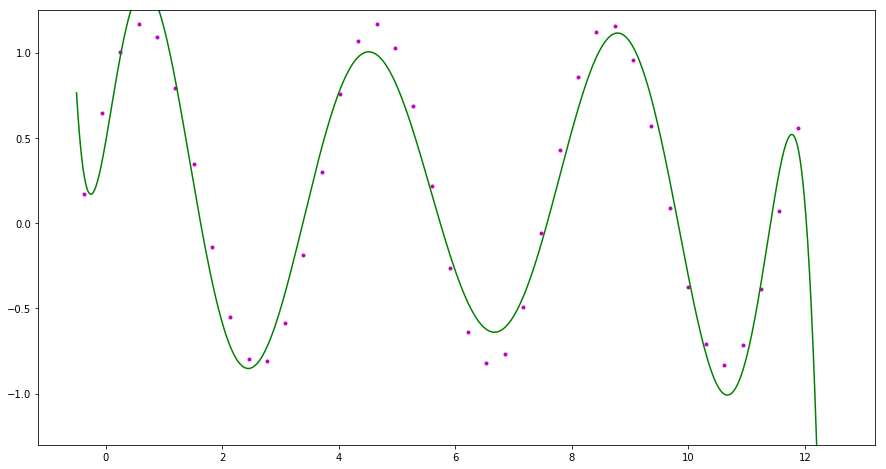

In [7]:
a = analytical_solution_without_regularizer(x, y, 10)
after_x = np.arange(-0.5, 2*T, 0.01)
after_y = func_solve(after_x, a)
plt.ylim([-1.3, 1.25])
plt.plot(x, y, color='m', linestyle='', marker='.')
plt.plot(after_x,after_y,color='g',linestyle='-',marker='')
plt.show()

### 使用有正则项的解析解（过度惩罚可能导致退化）

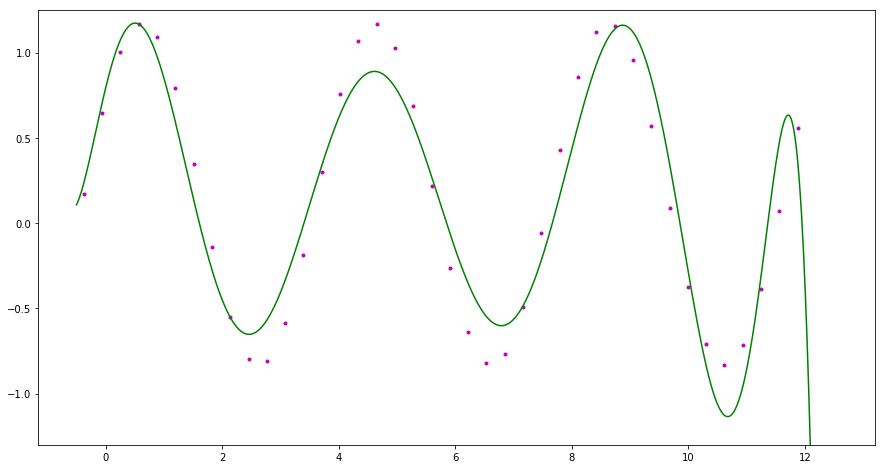

In [8]:
def analytical_solution_with_regularizer(x, y, order, regularizer):
    
    matrix_left = np.ones((len(x), order+1), dtype = float)
    
    for i in range(len(x)):
        for j in range(order+1):
            matrix_left[i][j] = x[i]**j
    
    return np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(matrix_left), matrix_left) +  regularizer * np.eye(order+1)), np.transpose(matrix_left)),  np.transpose(y))

a = analytical_solution_with_regularizer(x, y, 10, 0.1)
after_x = np.arange(-0.5, 2*T, 0.01)
after_y = func_solve(after_x, a)
plt.ylim([-1.3, 1.25])
plt.plot(x, y, color='m', linestyle='', marker='.')
plt.plot(after_x,after_y,color='g',linestyle='-',marker='')
plt.show()

### 使用梯度下降法拟合函数

定义代价函数及其梯度为：

![](https://tva1.sinaimg.cn/large/006y8mN6gy1g6z9rt8m3sj30cj02v0ss.jpg)

![](https://tva1.sinaimg.cn/large/006y8mN6gy1g6za6xpl3kj30ec05zjro.jpg)

In [66]:
# number of example points
m = len(x)
lam = np.exp(-18)

def loss_function(theta, X, y):
    temp = np.dot(X, theta) - y
    return (1.0 / (2 * m)) * np.dot(np.transpose(temp), temp)

def gradient_function(theta, X, y):
    temp = np.dot(X, theta) - y
    return (1.0 / m) * np.dot(np.transpose(X), temp) + lam * theta

梯度下降法

In [71]:
def gradient_decent(theta, alpha, X, y):
    # theta为初始位置（列向量）
    gradient = gradient_function(theta, X, y)
    while np.all(np.absolute(gradient) > 1e-5):
        print(gradient)
        theta = theta - alpha * gradient
        gradient = gradient_function(theta, X, y)
    return theta

使用梯度下降法拟合十阶多项式

[[5.57313981e+08]
 [6.08745501e+09]
 [6.70556370e+10]
 [7.43873980e+11]
 [8.30164648e+12]
 [9.31244031e+13]
 [1.04930710e+15]
 [1.18697394e+16]
 [1.34735018e+17]
 [1.53410227e+18]]
[[-7.82242142e+22]
 [-8.55250534e+23]
 [-9.42825829e+24]
 [-1.04658928e+26]
 [-1.16863166e+27]
 [-1.31153178e+28]
 [-1.47840107e+29]
 [-1.67294959e+30]
 [-1.89957233e+31]
 [-2.16345619e+32]]
[[1.10314863e+37]
 [1.20610796e+38]
 [1.32961012e+39]
 [1.47594145e+40]
 [1.64805044e+41]
 [1.84957385e+42]
 [2.08489951e+43]
 [2.35925953e+44]
 [2.67885189e+45]
 [3.05099134e+46]]
[[-1.55570376e+51]
 [-1.70090107e+52]
 [-1.87506869e+53]
 [-2.08143091e+54]
 [-2.32414581e+55]
 [-2.60834207e+56]
 [-2.94020761e+57]
 [-3.32712095e+58]
 [-3.77782271e+59]
 [-4.30262846e+60]]
[[2.19391487e+65]
 [2.39867786e+66]
 [2.64429590e+67]
 [2.93531605e+68]
 [3.27760219e+69]
 [3.67838698e+70]
 [4.14639687e+71]
 [4.69203733e+72]
 [5.32763475e+73]
 [6.06773654e+74]]
[[-3.09394537e+79]
 [-3.38271022e+80]
 [-3.72909049e+81]
 [-4.13949860e+82]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in add


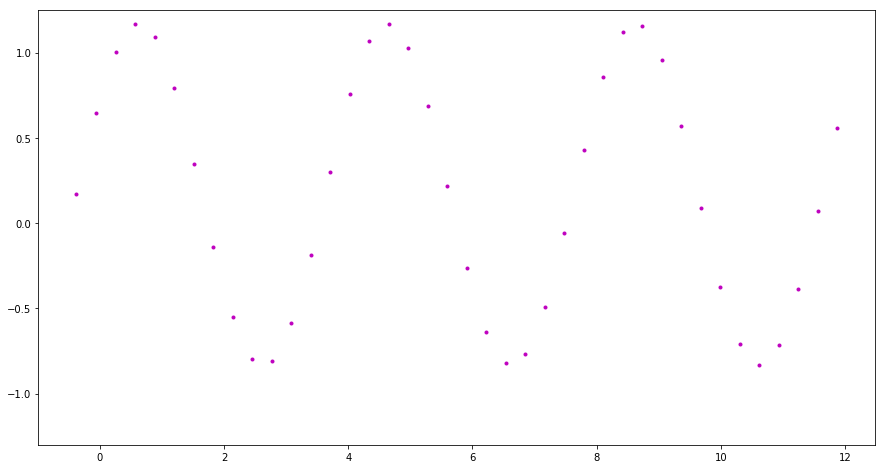

In [72]:
order = 9

theta = np.ones((order + 1, 1))
alpha = 0.0001

X = np.ones((m, order + 1))
for i in range(m):
    for j in range(order + 1):
        if j == 0:
            X[i][j] = 1
        else:
            X[i][j] = X[i][j-1] * x[i]

a = gradient_decent(theta, alpha, X, y.reshape(m, 1))

after_x = np.arange(-0.5, 2*T, 0.01)
after_y = func_solve(after_x, a)
plt.ylim([-1.3, 1.25])
plt.plot(x, y, color='m', linestyle='', marker='.')
plt.plot(after_x,after_y,color='g',linestyle='-',marker='')
plt.show()